## RSI 봇 백테스팅

Fetching data until 2025-08-24 20:16:50.472232
Fetching data until 2025-07-22 13:00:00
Fetching data until 2025-06-19 17:00:00


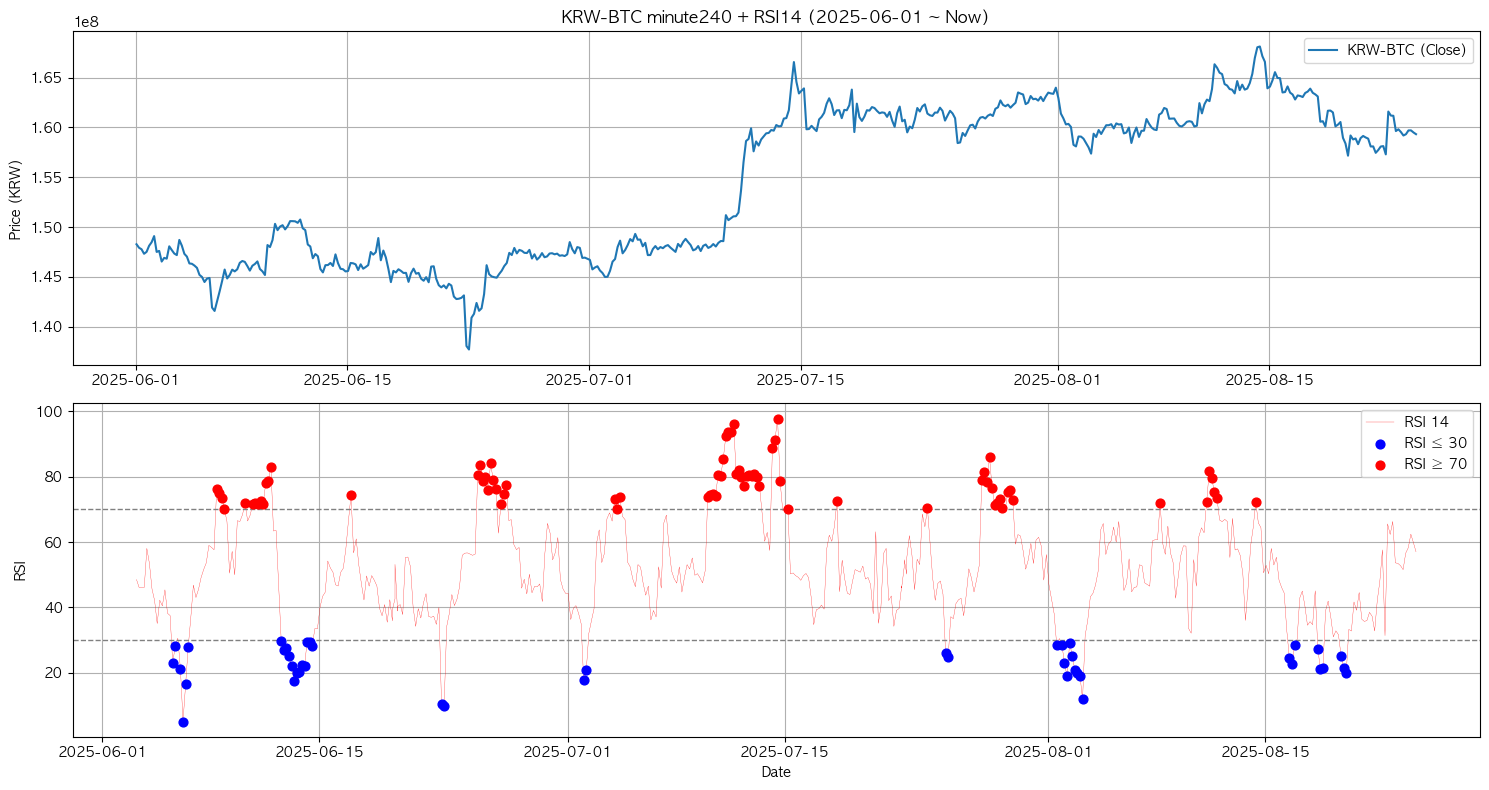


📌 [RSI 실시간 확인]
 - 최신 캔들 시작 시간: 2025-08-24 17:00:00
 - 현재 RSI14 값: 57.01
 - 참고용 이전 RSI 값: 59.79

📌 [시뮬레이션 전략 요약]
- 봇 실행 주기: 30분마다 실행
- 매수: RSI ≤ 30 → 현금의 20%씩 분할 매수 (최소 5,000원 이상)
- 매도: RSI ≥ 70일 때
       · 손실/본전 → 전량 매도
       · 수익률 ≥ 25% → 절반 매도
- 그 외 구간은 보유 유지

📌 시뮬레이션 실행 환경
 - 종목: KRW-BTC
 - 시작일: 2025-06-01
 - 차트 간격: minute240
 - 봇 실행 주기: 30분
 - 초기 자본: 3,000,000 원
 - 수수료율: 0.05%
 - 최소 거래 단위: 5,000 원

 - 캔들 주기: 240분 (4시간)
 - 조건 확인 기회: 8번
📊 과매도 구간 개수 (RSI ≤ 30): 44
📊 과매수 구간 개수 (RSI ≥ 70): 75
2025-06-05 21:00:00 매수: 144901000원 | 매수 금액: 600000원 | 평균 단가: 144973487원 | 잔여 현금: 2400000원
2025-06-06 17:00:00 매수: 144602000원 | 매수 금액: 480000원 | 평균 단가: 144840379원 | 잔여 현금: 1920000원
2025-06-14 17:00:00 매수: 145772000원 | 매수 금액: 384000원 | 평균 단가: 145102524원 | 잔여 현금: 1536000원
2025-06-23 05:00:00 매수: 140908000원 | 매수 금액: 307200원 | 평균 단가: 144370037원 | 잔여 현금: 1228800원
2025-07-02 09:00:00 매수: 145615000원 | 매수 금액: 245760원 | 평균 단가: 144529331원 | 잔여 현금: 983040원
2025-07-25 17:00:00 매수: 159451000원 | 매수 금액: 196608원 

In [9]:
# 환경변수 로딩 (.env)
#      ↓
# API 연결 및 초기값 설정
#      ↓
# 4시간봉 데이터 → RSI 계산
#      ↓
# 실시간 잔고 조회 (KRW, BTC, 평균단가)
#      ↓
# [조건 검사]
#   └─ RSI ≤ 매수기준 → 매수 실행
#   └─ RSI ≥ 매도기준
#        └─ 손실/본전 → 전량 매도
#        └─ 수익 ≥ 익절기준% → 절반 매도
#      ↓
# 모든 결과 Gmail 전송

import pyupbit
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import time

mpl.rcParams['font.family'] = 'AppleGothic'   # Mac 기본 한글 폰트
mpl.rcParams['axes.unicode_minus'] = False    # 음수(-) 깨짐 방지

# ======================
# 🔹 설정값 (여기만 수정해서 재사용 가능)
ticker = "KRW-BTC"
start_date = "2025-06-01"
interval = "minute240"
bot_interval = 30
fee = 0.0005
initial_capital = 3_000_000
min_trade = 5000

# 🔹 RSI 기준값
rsi_buy_threshold = 30
rsi_sell_threshold = 70

# 🔹 수익률 기준값
target_profit_percent = 25
# ======================

# 1️⃣ OHLCV 데이터 수집
all_data = []
to = datetime.now()

while True:
    data = pyupbit.get_ohlcv(ticker, interval=interval, to=to, count=200)
    print(f"Fetching data until {to}")
    if data is None or data.empty:
        break
    all_data.append(data)
    to = data.index[0]
    if to < pd.to_datetime(start_date):
        break
    time.sleep(0.3)

df = pd.concat(all_data)
df = df[df.index >= pd.to_datetime(start_date)]
df.sort_index(inplace=True)

# 2️⃣ RSI 14 계산
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

roll_up = pd.Series(gain).rolling(window=14).mean()
roll_down = pd.Series(loss).rolling(window=14).mean()

RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))
df["RSI14"] = RSI.values

# 3️⃣ RSI 시각화
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(df.index, df["close"], label=f"{ticker} (Close)")
plt.title(f"{ticker} {interval} + RSI14 ({start_date} ~ Now)")
plt.ylabel("Price (KRW)")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(df.index, df["RSI14"], color="red", label="RSI 14", linewidth=0.2)
plt.axhline(rsi_sell_threshold, color="gray", linestyle="--", linewidth=1)
plt.axhline(rsi_buy_threshold, color="gray", linestyle="--", linewidth=1)

oversold = df[df["RSI14"] <= rsi_buy_threshold]
overbought = df[df["RSI14"] >= rsi_sell_threshold]

plt.scatter(oversold.index, oversold["RSI14"], color="blue", s=40, zorder=5, label=f"RSI ≤ {rsi_buy_threshold}")
plt.scatter(overbought.index, overbought["RSI14"], color="red", s=40, zorder=5, label=f"RSI ≥ {rsi_sell_threshold}")

plt.ylabel("RSI")
plt.xlabel("Date")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n📌 [RSI 실시간 확인]")
print(f" - 최신 캔들 시작 시간: {df.index[-1]}")
print(f" - 현재 RSI14 값: {df['RSI14'].iloc[-1]:.2f}")
print(f" - 참고용 이전 RSI 값: {df['RSI14'].iloc[-2]:.2f}")

# ======================
print("\n" + "="*50)
print("📌 [시뮬레이션 전략 요약]")
print(f"- 봇 실행 주기: {bot_interval}분마다 실행")
print(f"- 매수: RSI ≤ {rsi_buy_threshold} → 현금의 20%씩 분할 매수 (최소 {min_trade:,}원 이상)")
print(f"- 매도: RSI ≥ {rsi_sell_threshold}일 때")
print("       · 손실/본전 → 전량 매도")
print(f"       · 수익률 ≥ {target_profit_percent}% → 절반 매도")
print("- 그 외 구간은 보유 유지")

# 실행 환경 출력
print("\n===============================")
print("📌 시뮬레이션 실행 환경")
print(f" - 종목: {ticker}")
print(f" - 시작일: {start_date}")
print(f" - 차트 간격: {interval}")
print(f" - 봇 실행 주기: {bot_interval}분")
print(f" - 초기 자본: {initial_capital:,} 원")
print(f" - 수수료율: {fee*100:.2f}%")
print(f" - 최소 거래 단위: {min_trade:,} 원")

# 주기 출력
print("\n===============================")
candle_minutes = int(interval.replace("minute", "")) if "minute" in interval else None
if candle_minutes and bot_interval:
    print(f" - 캔들 주기: {candle_minutes}분 ({candle_minutes//60}시간)")
    print(f" - 조건 확인 기회: {candle_minutes // bot_interval}번")
print("===============================")

print(f"📊 과매도 구간 개수 (RSI ≤ {rsi_buy_threshold}): {len(oversold)}")
print(f"📊 과매수 구간 개수 (RSI ≥ {rsi_sell_threshold}): {len(overbought)}")













# 4️⃣ 매매 시뮬레이션
capital = initial_capital
position = 0
avg_buy_price = 0

for i in range(len(df)):
    if i == 0:
        continue

    prev_rsi = df["RSI14"].iloc[i - 1]
    rsi = df["RSI14"].iloc[i]
    price = df["close"].iloc[i]

    # ✅ [매수 조건]
    # - 직전 RSI ≤ rsi_buy_threshold (과매도 상태)
    # - 현재 RSI > rsi_buy_threshold (반등 발생)
    # - 현금(capital)이 남아 있는 경우
    # → 조건 만족 시, 보유 현금의 20% 매수 (단, 최소 주문 금액 이상일 때만 실행)
    if prev_rsi <= rsi_buy_threshold and rsi > rsi_buy_threshold and capital > 0:
        invest_amount = capital * 0.2
        if invest_amount < min_trade:
            continue
        btc_amount = (invest_amount * (1 - fee)) / price
        total_cost = (avg_buy_price * position) + invest_amount
        position += btc_amount
        avg_buy_price = total_cost / position
        capital -= invest_amount
        print(f"{df.index[i]} 매수: {price:.0f}원 | 매수 금액: {invest_amount:.0f}원 | 평균 단가: {avg_buy_price:.0f}원 | 잔여 현금: {capital:.0f}원")

    # ✅ [매도 조건]
    # - RSI ≥ rsi_sell_threshold (과매수 상태)
    # - 보유 포지션이 있는 경우
    # → 수익률에 따라 아래 2가지로 분기:
    #   └─ 손실 or 본전 이하: 전량 매도
    #   └─ 수익률 ≥ target_profit_percent: 절반 익절
    elif rsi >= rsi_sell_threshold and position > 0:
        profit_rate = (price - avg_buy_price) / avg_buy_price * 100
        hold_value = position * price

        if hold_value < min_trade:
            continue

        # 📉 손실/본전 → 전량 매도
        if profit_rate <= 0:
            sell_value = hold_value * (1 - fee)
            capital += sell_value
            print(f"{df.index[i]} 전량 매도(손실/본전): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 수익률: {profit_rate:.2f}%")
            position = 0
            avg_buy_price = 0

        # 📈 수익률 충분 → 절반 매도
        elif profit_rate >= target_profit_percent:
            sell_amount = position / 2
            sell_value = (sell_amount * price) * (1 - fee)
            if sell_value < min_trade:
                continue
            capital += sell_value
            position -= sell_amount
            print(f"{df.index[i]} 절반 매도(익절): {price:.0f}원 | 매도 금액: {sell_value:,.0f}원 | 남은 {ticker}: {position:.6f} | 수익률: {profit_rate:.2f}%")

# 5️⃣ 최종 정산
final_value = capital + (position * df["close"].iloc[-1])
profit_rate = (final_value - initial_capital) / initial_capital * 100

print("="*50)
print(f"💰 최종 평가 금액: {final_value:,.0f} 원")
print(f"📈 총 수익률: {profit_rate:.2f}%")
print("="*50)
